In [1]:
%load_ext autoreload

%autoreload 2

In [17]:
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tracker.satellite import Satellite
from tracker.tle import TLE

In [3]:
zarya_tle_archive = None
archive_path = 'tle_files/zarya_2001-2018_tles.txt'

with open(archive_path, 'r') as f_archive:
    zarya_tle_archive = f_archive.read()
    
tle_lines = zarya_tle_archive.split('\n')[:-1]
tles = []

for i in range(0, len(tle_lines), 2):
    line1, line2 = tle_lines[i:i + 2]
    tle = TLE(line1, line2)
    tles.append(tle)

In [4]:
tles.sort(key=attrgetter('epoch'))
type(tles[0])

tracker.tle.TLE

In [11]:
def two_tle_error(tle1, tle2):
    OBS_LAT = -15.989620
    OBS_LON = -48.044411
    OBS_ALT = 500 # meters
    
    sat1 = Satellite(*tle1.tle)
    sat2 = Satellite(*tle2.tle)
    
    epoch1 = tle1.epoch
    epoch2 = tle2.epoch
    
    az1, el1 = sat1.get_observer_azimuth_elevation(OBS_LAT, OBS_LON, OBS_ALT, date=epoch2)
    az2, el2 = sat2.get_observer_azimuth_elevation(OBS_LAT, OBS_LON, OBS_ALT, date=epoch2)
    
    return abs(az1 - az2), abs(el1 - el2), epoch2 - epoch1

In [6]:
tle1 = tles[0]
tle2 = tles[1]

print(tle1.tle)

('1 25544U 98067A   17001.10660880  .00001073  00000-0  23630-4 0  9997', '2 25544  51.6423 151.2131 0007045  39.8224 315.5565 15.53964187 35761')


In [21]:
errors = [two_tle_error(tles[i - 1], tles[i]) for i in range(1, len(tles))]
az_errors = np.array([err[0] for err in errors])
el_errors = np.array([err[1] for err in errors])
date_delta_hours = np.array([err[2].total_seconds() / 3600.0 for err in errors])

In [24]:
error_table = pd.DataFrame(
    {'Azimuth error (degrees)': az_errors,
     'Elevation error (degrees)': el_errors,
     'Date delta (hours)': date_delta_hours})

display(error_table.head())

,Azimuth error (degrees),Elevation error (degrees),Date delta (hours)
0,0.000226,0.000076,1.484166
1,0.001001,0.000265,9.791784
2,0.000000,0.000000,0.000000
3,0.000639,0.000515,3.198929
4,0.003873,0.000846,7.614045


# Estatísticas dos erros e tempo de diferença entre TLE consecutivos

In [28]:
error_table.describe()

,Azimuth error (degrees),Elevation error (degrees),Date delta (hours)
count,2868.000000,2868.000000,2868.000000
mean,0.005727,0.003113,5.521666
std,0.042440,0.021275,5.752167
min,0.000000,0.000000,0.000000
25%,0.000088,0.000065,1.581811
50%,0.000752,0.000405,4.474303
75%,0.002614,0.001471,7.279420
max,1.332285,0.532718,52.952656


# Plotando os erros

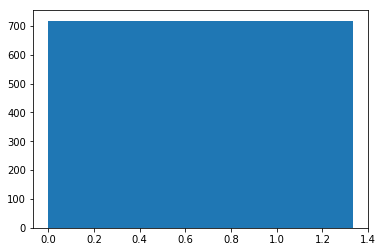

In [39]:
fig, ax = plt.subplots(1, 1)

plt.hist(az_errors, bins = [0.000088, 0.000752, 0.002614, 1.332285])
plt.ticklabel_format(style='sci', axis='x', scilimits=(-3,4), edgecolor='b', lw=100)
plt.show()